# Weather Stations & Fire Spread


## Setup

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/California FireTrends (2012-2020)" 

import os
rootPath = "/content/drive/My Drive/California FireTrends (2012-2020)/Variables/WeatherStation_FireSpread"
os.chdir(rootPath)

/content/drive/My Drive/FireDrivers_Paper


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       26751688 kB


In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import rtree

In [ ]:
import requests
import os
import re
import lxml.html as lh
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from urllib.request import urlopen

In [ ]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext):
              file_list.append(os.path.join(path,names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath 

## Obtain RAWS Station Info

In [ ]:
import re

stationName = [] 
stationAbbrv = [] 
mainURL = [] 
lat = [] 
long = [] 
startYr = [] 
endYr = [] 

# Station Name, Code, url, lat/long 
# find latest, earliest dates (Year, Month) for each station 
RegionList = ["ncalst", "ccalst", "scalst"]
root = "https://wrcc.dri.edu/"
for region in RegionList: 
    # https://wrcc.dri.edu/cgi-bin/rawMAIN.pl?nvNBLU
    # https://wrcc.dri.edu/cgi-bin/rawNAME.pl?nvNBLU
    # https://wrcc.dri.edu/cgi-bin/wea_info.pl?nvNBLU
    url = 'https://wrcc.dri.edu/wraws/'+ str(region) +'.html'
    html= urlopen(url)
    soup = BeautifulSoup(html,"lxml")
    text = soup.get_text()
    for text in soup.find_all('a', href=True):
        #print(text)
        binURL = re.search('href="(.*)" onmouseout=', str(text))
        result = re.search("> (.*)California </a>", str(text))
        if result is not None and binURL.group(1)[-3:] not in stationName:
            try: 
                #print(result.group(1), binURL.group(1), binURL.group(1)[-3:])
                dates = binURL.group(1).replace("rawMAIN", "rawNAME", 1)
                info = binURL.group(1).replace("rawMAIN", "wea_info", 1)
                datesURL = root + dates 
                infoURL =  root + info 
                #print(datesURL, infoURL)
                # get start/end dates 
                dateHtml= urlopen(datesURL)
                dateSoup = BeautifulSoup(dateHtml)
                #paragraphs = dateSoup.find_all('b')
                paragraphs = dateSoup.get_text()
                yrs = [int(s) for s in paragraphs.split() if s.isdigit() and len(s) == 4]
                #print(yrs[0], yrs[-1])
                #print(paragraphs)
                #Lat = re.search('<td><font color="#ff0000"> <b> (.*) </b>', str(paragraphs))
                datetext = dateSoup.get_text()
                infoHtml= urlopen(infoURL)
                infoSoup = BeautifulSoup(infoHtml)
                infotext = infoSoup.get_text()
                latMark = infotext.find('°') 
                latitude = infotext[latMark - 2 : latMark + 8]
                #print(latMark, infotext[latMark - 2 : latMark + 8])
                i = infotext.index('°')
                longMark = infotext.index('°', i + 1)
                #print(longMark, infotext[longMark - 3 : longMark + 8])
                longitude = infotext[longMark - 3 : longMark + 8]
                # append values to empty list 
                endYr.append(yrs[0])
                startYr.append(yrs[-1])
                lat.append(latitude)
                long.append(longitude)
                stationName.append(result.group(1))
                stationAbbrv.append(binURL.group(1)[-3:])
                mainURL.append(binURL.group(1))
            except: 
                continue
            
            


In [ ]:
RAWSInfoDF = pd.DataFrame({'Station': stationName, 'Abbrv': stationAbbrv, 
                          'URL': mainURL, 'latitude' : lat, 'longitude' : long,
                          'Start Year' : startYr, 'End Year' : endYr})

In [ ]:
# save df into csv 
outpath = 'data/RAWS/Raws_Info.csv'
RAWSInfoDF.to_csv(outpath, sep=',')

In [ ]:
# convert degrees to actual coordinate values 

import numpy as np
RAWSInfoDF = pd.read_csv(outpath, sep=',')
RAWSInfoDF = RAWSInfoDF.drop(columns=['Unnamed: 0'])
RAWSInfoDF['latitude'] = (RAWSInfoDF['latitude'] + '.00"N')
RAWSInfoDF['longitude'] = (RAWSInfoDF['longitude'] + '.00"W')
RAWSInfoDF

import re

def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'W' or direction == 'N':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])

    return (lat)

In [ ]:
#dd = parse_dms("78°55'44.33324"N )

decimal_Lat = [] 
decimal_Long = [] 
for index, row in RAWSInfoDF.iterrows():
    decimal_Lat.append(parse_dms(row[3]))
    decimal_Long.append(-1 * parse_dms(row[4]))
    #print(parse_dms(row[6]), -1 * parse_dms(row[7]))

RAWSInfoDF["decimal_Lat"] = decimal_Lat
RAWSInfoDF["decimal_Long"] = decimal_Long
RAWSInfoDF

In [ ]:
# if end Year is less than 2000 then drop 
RAWSInfoDF.columns = RAWSInfoDF.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
RAWSInfoDF = RAWSInfoDF[RAWSInfoDF.end_year > 2000].reset_index(drop=True)
#RAWSInfoDF = RAWSInfoDF.drop(columns=['level_0', 'index', 'unnamed:_0'])
#replace with new df 
outpath = 'data/RAWS/Raws_Info.csv'
RAWSInfoDF.to_csv(outpath, sep=',')
RAWSInfoDF

## Read-in Data

In [ ]:
# raws_shp_list = lstFiles("data/RAWS", ".shp")
raws_info = pd.read_csv("data/RAWS/Raws_Info.csv")
raws_info = raws_info.drop(columns=['Unnamed: 0'])

In [ ]:
import matplotlib.pyplot as plt
import shapely.geometry as geom
import numpy as np
import pandas as pd
import geopandas as gpd

geometry = [Point(xy) for xy in zip(raws_info.decimal_long, raws_info.decimal_lat)]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(raws_info, crs=crs, geometry=geometry)
geo_df.sort_values(by=['station'])

In [ ]:
fr_per = lstFiles(f'/content/drive/My Drive/California FireTrends (2012-2020)/Products/By_Fire', '.shp')

fire_list = []
year_list = []

for pth in fr_per:
  pth_nm = pth.split('/')
  nm = os.path.basename(pth)
  nm = nm.split('_')
  fr = pth_nm[8]
  yr = nm[1]
  fire_list.append(fr)
  year_list.append(yr)

In [ ]:
len(list(zip(fire_list, year_list)))
list(zip(fire_list, year_list))

## Download RAWS Hourly Data as CSV

In [ ]:
def getPerimeter(fire_nm, year):
  fire_nm_B = fire_nm.replace(' ', '')
  per_gdf = gpd.read_file(f'/content/drive/My Drive/California FireTrends (2012-2020)/Products/By_Fire/{year}/{fire_nm}/{fire_nm_B}_{year}_NAT.shp')
  return per_gdf

def getNearestStation(fire_nm, year, raws_gdf):
  per_gdf = getPerimeter(fire_nm, year)
  per_gdf['geometry'] = per_gdf.buffer(5000)
  raws_gdf = raws_gdf.to_crs(per_gdf.crs)
  res_intersection = gpd.overlay(raws_gdf, per_gdf, how='intersection', keep_geom_type=True)
  return res_intersection['station'].unique().tolist()

def getStationInfo(fire_nm, year, raws_gdf):
  station_list = getNearestStation(fire_nm, year, raws_gdf)
  raws_df = geo_df[geo_df['station'].isin(station_list)].drop_duplicates()
  df = getPerimeter(fire_nm, year)
  
  raws_df['Fire_Start_Date'] = df['Date'].min()
  raws_df['Fire_End_Date'] = df['Date'].max()

  raws_df['Fire_Start_Date'] =  pd.to_datetime(raws_df['Fire_Start_Date'], format='%Y-%m-%d')
  raws_df['Fire_End_Date'] =  pd.to_datetime(raws_df['Fire_End_Date'], format='%Y-%m-%d')

  raws_df['Fire'] = fire_nm

  return raws_df

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup

In [ ]:
def scrape_data(url, fname, fire_yr, dt, station_name):
    response = requests.get(url, timeout=10)
    soup = BeautifulSoup(response.content, 'html.parser')
    table_rows = soup.find_all("tr",attrs={"class": "data"})

    data_val = []
    for dta in table_rows[:-4]: 
      td = dta.find_all('td')
      row = [i.text.replace('\n', ' ').strip() for i in td]
      row_witout_empty = list(filter(lambda x: x != '', row))
      
      data_val.append(row_witout_empty)

    
    row_head = ['Hour', 'Total_Solar_Rad', 'Wind_Avg_mph', 'Wind_Dir_Deg', 
                'Wind_Max_mph', 'Air_Temp_Avg', 'Fuel_Temp_Avg', 'Fuel_Moist_Per',
                'Rel_Hum_Per', 'Dew_Point_Deg', 'Wet_Bulb', 'Total_Precip']
    
    if len(data_val) != 0 and os.path.exists(os.path.join('data/RAWS_CSV', fire_yr, fname, f'{fname}_{dt}_{station_name.strip()}.csv')) == False: 
      yr_out = createFolder('data/RAWS_CSV', fire_yr)
      f_out = createFolder(yr_out, fname)
      with open(os.path.join(f_out, f'{fname}_{dt}_{station_name.strip()}.csv'), 'w') as csv_file:
          writer = csv.writer(csv_file)
          writer.writerow(row_head)
          for row in data_val:
              writer.writerow(row)

In [ ]:
import datetime
from datetime import date

def retrieveRAWS_saveIntoCSV(fire_nm, fire_yr, geo_df):
  df = getStationInfo(fire_nm, fire_yr, geo_df)
  for index, rows in df.iterrows(): 
    # grab fire, weather station name, url 
    sta_name = rows.station 
    start_date = rows.Fire_Start_Date - datetime.timedelta(days=2)
    end_date = rows.Fire_End_Date
    delta = end_date - start_date

    # get range of dates
    date_list = [end_date - datetime.timedelta(days=x) for x in range(delta.days)]

    for dy in date_list: 
      if rows.end_year >= dy.year:
        # plug into url 
        dy_str = str(dy.day)
        mth_str = str(dy.month).zfill(2)
        yr_str = str(dy.year)
        print(dy_str, mth_str, yr_str)
        url = f'https://raws.dri.edu/cgi-bin/wea_daysum2.pl?stn=c{rows.abbrv.lower()}&day={dy_str}&mon={mth_str}&yea={yr_str[-2:]}&unit=E'
        print(url)
        
        # web scrap 
        dt = yr_str + mth_str + dy_str
        scrape_data(url, rows.Fire, fire_yr, dt, rows.station)

In [ ]:
for fire_nm, fire_yr in list(zip(fire_list, year_list)):
  if os.path.exists(os.path.join('data/RAWS_CSV', fire_yr, fire_nm)) == False:
    print(fire_nm, fire_yr)
    retrieveRAWS_saveIntoCSV(fire_nm, fire_yr, geo_df)

In [ ]:
retrieveRAWS_saveIntoCSV('Thomas', '2017', geo_df)

### Clean up CSV

In [ ]:
# add fire name, date, datetime, station name
csv_list = lstFiles('data/RAWS_CSV', '.csv')

def cleanCSV(csv_list):
  for csv in csv_list: 
    try: 
      nm = os.path.basename(csv)
      fr_nm = nm.split('_')[0]
      dt = nm.split('_')[1]
      st_nm = nm.split('_')[2][:-4]

      df = pd.read_csv(csv)
      df['Fire'] = fr_nm
      df['Date'] = dt

      df['Datetime'] = df['Date'].str.cat(df['Hour'],sep=" ")  
      df['Datetime'] =  pd.to_datetime(df['Datetime'], format='%Y%m%d %I %p')

      df['station'] = st_nm

      df.iloc[-1, df.columns.get_loc('Datetime')] = df.iloc[-1, df.columns.get_loc('Datetime')] + datetime.timedelta(days=1) 

      df.to_csv(csv)
      print(csv)
    except: 
      print('error', csv)
      continue

In [ ]:
cleanCSV(csv_list)

In [ ]:
# import glob, os

# thomas_archive = glob.glob(os.path.join('data/RAWS_CSV/2017', 'Thomas', '*.csv'))
# cleanCSV(thomas_archive)

### Combine CSVS 

In [ ]:
raws_df = raws_info[['station', 'decimal_lat',	'decimal_long',	'geometry']]
raws_df = raws_df.applymap(lambda x: x.strip() if type(x)==str else x)

def combineCSV_byFire(fire_nm, fire_yr):
  csv_list = lstFiles(f'data/RAWS_CSV/{fire_yr}/{fire_nm}', '.csv')

  if len(csv_list) != 0 and os.path.exists(f"data/Final_CSV/{fire_nm}_{fire_yr}_RAWS.csv") == False:
    #combine all files in the list
    combined_csv = pd.concat([pd.read_csv(f, index_col=None) for f in csv_list])
    if 'Unnamed: 0' in combined_csv.columns.tolist():
      combined_csv = combined_csv.drop(columns=['Unnamed: 0'])
    #export to csv
    final_df = pd.merge(combined_csv, raws_df, how='left', on='station')
    final_df.to_csv( f"data/Final_CSV/{fire_nm}_{fire_yr}_RAWS.csv", index=False)


In [ ]:
for fire_nm, fire_yr in list(zip(fire_list, year_list)):
  
  try: 
    combineCSV_byFire(fire_nm, fire_yr)
    print(fire_nm, fire_yr)
  except: 
    print('error', fire_nm, fire_yr)

In [ ]:
combineCSV_byFire('Thomas', '2017')

##  Weather Variable Calculations
VPD and Temp Conversions

In [ ]:
import math
def calculateVPD(Temp_val, RH_val):
  '''
  returns VPD based on temp and rel humidity values
  '''
  VP_sat = 0.61078 * math.exp((Temp_val * 17.2694) / (Temp_val + 238.3))
  VP_air = (VP_sat * RH_val) / 100 
  VPD = VP_sat - VP_air 
  return VPD

In [ ]:
def convertTemp_FtoC(Temp_val):
  '''
  converts F to C temperature
  '''
  C_TEMP = ((Temp_val - 32) * 5 ) / 9 
  return C_TEMP

## From Hourly to Daily Averages 
Based on time where day = 6am to 6pm and night = 7pm to 5am

In [ ]:
night_list = ['7 pm', '8 pm', '9 pm', '10 pm','11 pm', '12 am','1 am', '2 am','3 am', '4 am', '5 am']
day_list = ['6 am', '7 am', '8 am', '9 am', '10 am','11 am', '12 pm','1 pm', '2 pm','3 pm', '4 pm', '5 pm', '6 pm']

def getDailyRAWS(rim_df):
  '''
  converts hourly RAWS to daily (night vs day). keeps only day.
  '''
  rim_df = rim_df.dropna(subset=['Date'])
  criteria = [rim_df['Hour'].isin(day_list), rim_df['Hour'].isin(night_list)]
  values = ['Day', 'Night']
  rim_df['Day_Night']  = np.select(criteria, values, 0)
  day_raws_df = rim_df.groupby(by=['Day_Night', 'Date', 'Fire']).agg({'Total_Solar_Rad': 'mean', 
                                                                    'Wind_Avg_mph': 'mean',
                                                                    'Wind_Dir_Deg': 'mean',
                                                                    'Wind_Max_mph': ['mean', 'max'],
                                                                    'Air_Temp_Avg': ['mean', 'max'],
                                                                    'Fuel_Temp_Avg': 'mean',
                                                                    'Fuel_Moist_Per': 'mean',
                                                                    'Rel_Hum_Per': 'mean',
                                                                    'Dew_Point_Deg': 'mean',
                                                                    'Wet_Bulb': 'mean',
                                                                    'Total_Precip': 'mean'}).reset_index()
  day_raws_df.columns = ['Day_Night', 'Date', 'Fire', 'Total_Solar_Rad', 'Wind_Avg_mph',
       'Wind_Dir_Deg', 'Wind_Max_Avg', 'Wind_Max_mph', 'Air_Temp_Avg', 'Air_Temp_Max',
       'Fuel_Temp_Avg', 'Fuel_Moist_Per', 'Rel_Hum_Per', 'Dew_Point_Deg',
       'Wet_Bulb', 'Total_Precip']

  day_raws_df['Air_Temp_Celcius'] = convertTemp_FtoC(day_raws_df['Air_Temp_Avg'])
  day_raws_df['Air_Temp_Max_Celcius'] = convertTemp_FtoC(day_raws_df['Air_Temp_Max'])
  day_raws_df['VPD'] = day_raws_df.apply(lambda x: calculateVPD(x['Air_Temp_Celcius'],x['Rel_Hum_Per']),axis=1)
  day_raws_df = day_raws_df[day_raws_df['Day_Night'] == 'Day']
  day_raws_df['Date'] = day_raws_df['Date'].astype('str')
  day_raws_df['Date'] = pd.to_datetime(day_raws_df['Date'], format= '%Y%m%d')
  day_raws_df['Date'] =  day_raws_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
  return day_raws_df


def getDailyRAWS_byFire(fire_nm, fire_yr):
  rim_df = pd.read_csv(f"data/Final_CSV/{fire_nm}_{fire_yr}_RAWS.csv")
  return getDailyRAWS(rim_df)

## Get derived perimeter info

In [ ]:
fl_path = '/content/drive/My Drive/California FireTrends (2012-2020)/FinalCSV_Info'

def getDerivedDF(fl_path):
  derived_df = pd.read_csv(os.path.join(fl_path, 'FireInfoVar_Final.csv'), index_col=None)
  derived_df['YearJD'] = derived_df['Year'].astype('str').str.cat(derived_df['JulianDay'].astype('str'),sep="")  
  derived_df['Date'] = pd.to_datetime(derived_df['YearJD'], format= '%Y%j')
  derived_df['Date'] =  derived_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
  derived_df['Datetime'] = derived_df['Date'] + ' 23:00:00'
  derived_df['Area (ha)'] = derived_df['Area (ha)'] / 1000 
  return derived_df

### Visualize Time-series

In [ ]:
import os
rootPath = "/content/drive/My Drive/California FireTrends (2012-2020)"
os.chdir(rootPath)

In [ ]:
raws_pth = f'Final_Compiled_CSV/raws_compiled_2012_2020.csv'
raws_df = pd.read_csv(raws_pth, index_col=None)


gridmet_pth = f'Final_Compiled_CSV/gridmet_compiled_2012_2020.csv'
gridmet_df = pd.read_csv(gridmet_pth, index_col=None)

In [ ]:
raws_df['Air_Temp_Celcius'] = convertTemp_FtoC(raws_df['Air_Temp_Avg'])
raws_df['Air_Temp_Max_Celcius'] = convertTemp_FtoC(raws_df['Air_Temp_Max'])

In [ ]:
raws_df['Magnitude (upperQ)'] = raws_df['Magnitude (upperQ)'] / 100
raws_df['Magnitude (median)'] = raws_df['Magnitude (median)']  / 100

In [ ]:
raws_df['Area (ha)'] = raws_df['Area (ha)'] / 10
raws_df['Area (ha)'] = raws_df['Area (ha)']  / 10

In [ ]:
raws_df.Fire.unique()

array(['Ferguson', 'Ranch', 'Thomas', 'Carr', 'Camp', 'Woolsey', 'County',
       'River', 'Holy', 'Cranston', 'Alder', 'Eden', 'Eel', 'Eastern',
       'Mill Creek 1', 'Rush', 'Chips', 'Bagley', 'Mill', 'Ponderosa',
       'Jawbone', 'Wye', 'Walker', 'Pass', 'Stafford', 'Scotts',
       'Williams', 'Gaines', 'North Pass', 'Fort Bagley', 'Rim',
       'American', 'Mountain', 'Salmon', 'Summit', 'White', 'Carstens',
       'Branch', 'Water', 'Oak', 'Detwiler', 'Atlas', 'Pier', 'Tubbs',
       'Cove', 'Alamo', 'Haypress', 'Whittier', 'Pocket', 'Cascade',
       'Cedar', 'Cherokee', 'Clear', 'Wall', 'Manzanita', 'Ukonom',
       'Fourmile', 'Garden', 'Caldwell', 'Mission', 'Cristianitos',
       'Long Valley', 'Canyon 2', 'La Tuna', 'South Fork', 'Tenaja',
       'Cave', 'Kincade', 'Saddle Ridge', 'Tulley', 'Sacata', 'Meadow',
       'Sherpa', 'Pilot', 'Rey', 'Sand', 'Erskine', 'Chimney', 'Soup 2',
       'Owens River', 'Blue Cut', 'Gulch', 'Shirley', 'Way', 'Beaver',
       'Bald', 'July

In [ ]:
# Get daily RAWS based on fire name and year 
fire_nm = 'Camp'
fire_yr = '2020'
# day_raws_df = getDailyRAWS_byFire(fire_nm, fire_yr)
# fire_df = getPerimeter(fire_nm, fire_yr)
# merged_df = pd.merge(day_raws_df, fire_df, how='left', on='Date')

merged_df = raws_df[raws_df['Fire'] == fire_nm]

In [ ]:
wind_df_plot = merged_df[[
 'Date',
 'Air_Temp_Celcius',
 'Wind_Avg_mph'
 ]]

wind_df_plot = wind_df_plot.set_index('Date')
wind_df_plot = wind_df_plot.sort_index()

area_df_plot = merged_df[[
 'Date',
 'Area (ha)',
 'Magnitude (upperQ)',
 'Magnitude (median)',
 ]]
area_df_plot = area_df_plot.set_index('Date')
area_df_plot = area_df_plot.sort_index()

weather_df_plot = merged_df[[
 'Date',
 'VPD'
 ]]

weather_df_plot = weather_df_plot.set_index('Date')
weather_df_plot = weather_df_plot.sort_index()


maxWeather_df_plot = merged_df[[
 'Date',
 'Air_Temp_Max_Celcius',
 'Wind_Max_mph',
 ]]


maxWeather_df_plot = maxWeather_df_plot.set_index('Date')
maxWeather_df_plot = maxWeather_df_plot.sort_index()

<Figure size 432x288 with 0 Axes>

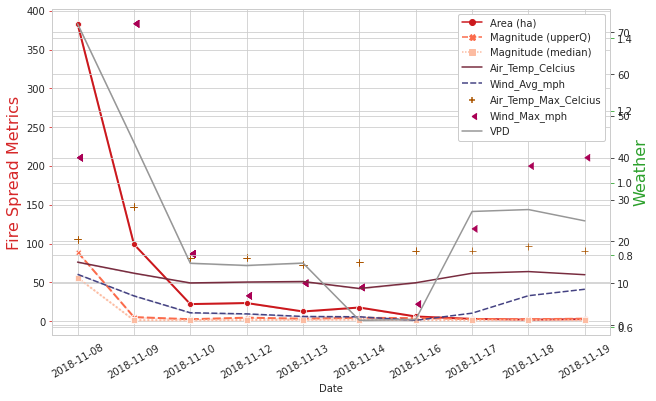

In [ ]:
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True, 'framealpha':1})
sns.despine(offset=10, trim=True);

plot_options = {'labelrotation':30}

r_color = 'tab:red' # Area, Magnitude
g_color = 'tab:green' # Wind 
o_color = 'tab:orange' # Weather 

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_ylabel('Fire Spread Metrics', fontsize=16, color=r_color)
ax1 = sns.lineplot(data = area_df_plot, markers=True, palette='Reds_r', linewidth = 2)
ax1.tick_params(axis='y', color=r_color)
ax1.tick_params(axis='x', **plot_options)
ax1.legend(loc='upper right') 

ax2 = ax1.twinx()
ax2.set_ylabel('Weather', fontsize=16, color=g_color)
ax2 = sns.lineplot(data = wind_df_plot, palette='icefire_r')
ax2 = sns.scatterplot(data = maxWeather_df_plot, 
                      palette='brg_r', 
                      markers=['+', 4],
                      s=50)
ax2.legend(loc='upper right') 

ax3 = ax1.twinx()
ax3 = sns.lineplot(data = weather_df_plot, palette='Greys_r')
ax3.tick_params(axis='y', color=g_color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right', framealpha=1)

fig.savefig(f'Figures/{fire_nm}_{fire_yr}_Wind_RAWSPlot.png', dpi=400)

Take Daily Average i.e. Values During DayTime 6am to 6pm 

### Daily Fuel

In [ ]:
fuel_df_plot = merged_df[[
 'Date', 'Barren',
 'Developed',
 'Conifer',
 'Grassland',
 'Hardwood',
 'Riparian',
 'Shrubland',
 'Sparsely Vegetated']]

fuel_df_plot = fuel_df_plot.drop_duplicates()

fuel_df_plot = fuel_df_plot.set_index('Date').fillna(0)
fuel_df_plot = fuel_df_plot.sort_index()


area_df_plot = merged_df[[
 'Date',
 'Area (ha)',
 'Magnitude (upperQ)', 
 'Magnitude (median)'
 ]]

area_df_plot = area_df_plot.set_index('Date')
area_df_plot = area_df_plot.sort_index()

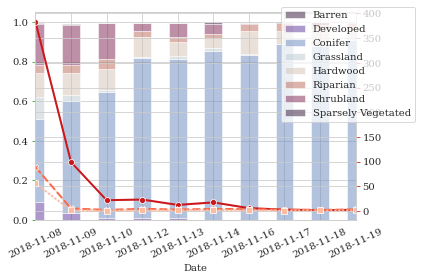

In [ ]:
#fig, ax1 = plt.subplots(figsize=(10,6))
plot_options = {'labelrotation':25}
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


color = 'tab:green'
ax1.set_ylabel('Fuel (%) ', fontsize=16, color=color)
ax1 = fuel_df_plot.plot(kind='bar',stacked=True,legend=False, cmap='twilight_shifted', alpha=0.5)
ax1.tick_params(axis='y', color=color)
ax1.tick_params(axis='x', **plot_options)


ax2 = ax1.twinx()
color = 'tab:red'
# ax2.set_ylabel('Fire Spread', fontsize=16, color=color)
ax2 = sns.lineplot(data = area_df_plot, markers=True, legend=False, palette='Reds_r', linewidth = 2)
ax2.tick_params(axis='y', color=color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2 , labels + labels2 , bbox_to_anchor=(1.20, 1.05), framealpha=0.75)

plt.xlim(merged_df.Date.min(), merged_df.Date.max())
plt.tight_layout()
plt.savefig(f'Figures/{fire_nm}_{fire_yr}_Fuelplot.png', dpi=400)

## RAWS Analysis

In [ ]:
import os
rootPath = "/content/drive/My Drive/California FireTrends (2012-2020)"
os.chdir(rootPath)

In [ ]:
raws_pth = f'Final_Compiled_CSV/RAWS_fullday_2012_2020.csv'
raws_df = pd.read_csv(raws_pth, index_col=None)


gridmet_pth = f'Final_Compiled_CSV/gridmet_compiled_2012_2020.csv'
gridmet_df = pd.read_csv(gridmet_pth, index_col=None)

In [ ]:
# Rename variables 
def renameVars(df):
  df = df.rename(columns={'bi': 'BurningIndex', 
                          'erc': 'ERC',
                          'eto': 'Ref_ET_G', 
                          'etr': 'Ref_ET_A', 
                          'fm100': 'DFM100hr', 
                          'fm1000':'DFM1000hr', 
                          'pr':'precip',
                          'rmax': 'RH_Max', 
                          'rmin': 'RH_Min', 
                          'sph': 'spec_hum', 
                          'srad': 'solar_rad', 
                          'th':  'Wind_Dir',
                          'tmmn': 'Temp_Min', 
                          'tmmx': 'Temp_Max', 
                          'vpd': 'VPD_Mean', 
                          'vs': 'Wind_Speed', 
                        'NA_L3NAME': 'EcoRegion',
                      'shortHeight': 'VegHeight_0.5m', 
                      'medShortHeight':'VegHeight_1m', 
                      'medHeight':'VegHeight_1m+',
                      })
  return df

raws_df = renameVars(raws_df)
gridmet_df = renameVars(gridmet_df)


In [ ]:
# response var: 0
# topo: 1 
# weather : 2 
# fuel amount: 3 
# gridmet_wind : 4
# gridmet_VPD : 5
# gridmet_Temp : 6
# fuel condition: 7
# human: 8 
# fuel type: 9
# fuel height: 10
# raws_wind : 11
# raws_VPD : 12
# gridmet_Temp : 12


raws_vars_list = { 
#  'Magnitude (median)': 0 ,
#  'Magnitude (upperQ)': 0 ,
 'Total_Solar_Rad': 2,
 'Wind_Avg_mph': 4,
#  'Wind_Dir_Deg': 4,
 'Wind_Max_Avg': 4,
 'Wind_Max_mph': 4,
 'Air_Temp_Avg': 6,
 'Air_Temp_Max': 6,
 'Fuel_Temp_Avg': 7,
 'Fuel_Moist_Per': 7,
 'Rel_Hum_Per': 2,
 'Dew_Point_Deg': 2,
 'Wet_Bulb': 2,
 'Total_Precip': 2,
 'Air_Temp_Celcius': 6,
 'Air_Temp_Max_Celcius': 6,
 'VPD': 5,
 }

In [ ]:
gridmet_vars_list = { 
 'Annual_EVI': 3,
 'Annual_NDMI': 3,
 'Annual_NDVI': 3,
 'Aspect': 1,
 'DEM': 1,
 'EVI': 7,
 'FFWI': 2,
 'NDMI': 7,
 'NDMIDelta': 7,
 'NDVI':7,
 'Slope': 1,
 'TOPO_DIV': 1,
 'BurningIndex' :2,
 'ERC':2,
 'Ref_ET_G':7,
 'Ref_ET_A':7,
 'DFM100hr':7,
 'DFM1000hr':7,
 'precip':2,
 'RH_Max':2,
 'RH_Min':2,
 'spec_hum':2,
 'solar_rad':2,
#  'Wind_Dir':4,
 'Temp_Min':6,
 'Temp_Max':6,
 'travelCost':8,
 'VPD_Mean':5,
 'Wind_Speed':4,
 'CBD':3,
 'FBFM1':7,
 'FBFM2':7,
 'FBFM3':7,
 'FBFM4':7,
 'FBFM5':7,
 'FBFM6':7,
 'FBFM7':7,
 'FBFM8':7,
 'FBFM9':7,
 'FBFM10':7,
 'FBFM11':7,
 'FBFM12':7,
 'Valley':7,
 'LowerSlope':1,
 'MidSlope':1,
 'UpperSlope':1,
 'Ridge':1,
 'VegHeight_0.5m':10,
 'VegHeight_1m':10,
 'VegHeight_1m+':10,
 'TreeHeight_5m':10,
 'TreeHeight_10m':10,
 'TreeHeight_25m':10,
 'TreeHeight_50m':10,
 'TreeHeight_50m+':10,
 'Barren':9,
 'Conifer':9,
#  'Developed':9,
 'Grassland':9,
 'Hardwood':9,
 'Riparian':9,
 'Shrubland':9,
 'Sparsely Vegetated':9,
 }

In [ ]:
def updateEcoNames(spreadFile):
  spreadFile.loc[spreadFile.ecoID == 5, 'EcoRegion'] = "Northern Coastal Sage"
  spreadFile.loc[spreadFile.ecoID == 11, 'EcoRegion'] = "Southern Coastal Sage"
  spreadFile.loc[spreadFile.ecoID == 8, 'EcoRegion'] = "Southern/Baja"
  spreadFile.loc[spreadFile.ecoID == 2, 'EcoRegion'] = "Southern/Baja"
  spreadFile.loc[spreadFile.ecoID == 2, 'ecoID'] = 8
  spreadFile.loc[spreadFile.ecoID == 1, 'EcoRegion'] = "Northern Coastal Sage"
  spreadFile.loc[spreadFile.ecoID == 1, 'ecoID'] = 5
  spreadFile.loc[spreadFile.ecoID == 0, 'EcoRegion'] = "Klamath Mountains"
  spreadFile.loc[spreadFile.ecoID == 0, 'ecoID'] = 7
  spreadFile.loc[spreadFile.ecoID == 12, 'EcoRegion'] = "Cascades"
  spreadFile.loc[spreadFile.ecoID == 12, 'ecoID'] = 3
  spreadFile.loc[spreadFile.ecoID == 6, 'EcoRegion'] = "Northern Coastal Sage"
  spreadFile.loc[spreadFile.ecoID == 6, 'ecoID'] = 5
  spreadFile.loc[spreadFile.ecoID == 9, 'EcoRegion'] = "Klamath Mountains"
  spreadFile.loc[spreadFile.ecoID == 9, 'ecoID'] = 7
  spreadFile.loc[spreadFile.ecoID == 10, 'EcoRegion'] = "Southern Coastal Sage"
  spreadFile.loc[spreadFile.ecoID == 10, 'ecoID'] = 11
  return spreadFile

In [ ]:
def get_correlation(filt_df, x, response_Var, var_list, source):
  for key in var_list: 
    df = filt_df[filt_df[x] == key]
    corr_val = df[response_Var].corr(df['value'])
    eco_region.append(ecoID)
    ind.append(ecounique)
    var_nm.append(key)
    r_val.append(abs(corr_val))
    class_val.append(var_list[key])
    hue_val.append(q)
    src.append(source)
    # res_val.append(response_Var)

In [ ]:
def createCorrDF(orig_df, source, response_Var, resvar, var_list):
  for i in range(0, 90 + 1, 5): 
    q = i/100
    Top25_area_val = orig_df[response_Var].quantile(q)
    top25_area = orig_df[orig_df[response_Var] >= Top25_area_val].reset_index()
    top25_area = top25_area[['Date', 'Fire']]
    merged_rim_df = pd.merge(top25_area, orig_df, how='left', on=['Date', 'Fire'])
    merged_rim_df = updateEcoNames(merged_rim_df)
    ecoID_List = merged_rim_df['EcoRegion'].unique().tolist()
    ecoID_name = [s + f'_{str(i)}' for s in ecoID_List]
    ecoID, ecounique = ('ALL', 'ALL')
    for ecoID, ecounique in list(zip(ecoID_List, ecoID_name)): 
      df  = merged_rim_df[(merged_rim_df['EcoRegion'] == ecoID)]
      filt_df = pd.melt(df, id_vars=['Fire', 'JulianDay', 'Area (ha)', 'log(Area)', 'log(magnitude)', 'Magnitude (upperQ)'], value_vars=list(var_list.keys())).dropna()
      for key in var_list: 
        df = filt_df[filt_df['variable'] == key]
        corr_val = df[response_Var].corr(df['value'])
        eco_region.append(ecoID)
        ind.append(ecounique)
        var_nm.append(key)
        r_val.append(abs(corr_val))
        class_val.append(var_list[key])
        hue_val.append(q)
        src.append(source)

In [ ]:
eco_region = []
r_val = []
var_nm = [] 
class_val = []
hue_val = []
ind = []
src = []


resvar = 'area'
gridmet_df['log(Area)'] = np.log(gridmet_df['Area (ha)'])
raws_df['log(Area)'] = np.log(raws_df['Area (ha)'])
createCorrDF(gridmet_df, 'gridmet', 'Area (ha)', resvar, gridmet_vars_list)
createCorrDF(raws_df, 'raws', 'Area (ha)', resvar, raws_vars_list)

# resvar = 'log_area'
# gridmet_df['log(Area)'] = np.log(gridmet_df['Area (ha)'])
# raws_df['log(Area)'] = np.log(raws_df['Area (ha)'])
# createCorrDF(gridmet_df, 'gridmet', 'log(Area)', resvar, gridmet_vars_list)
# createCorrDF(raws_df, 'raws', 'log(Area)', resvar, raws_vars_list)

# resvar = 'log_magnitude'
# gridmet_df['log(magnitude)'] = np.log(gridmet_df['Magnitude (upperQ)'])
# raws_df['log(magnitude)'] = np.log(raws_df['Magnitude (upperQ)'])
# createCorrDF(gridmet_df, 'gridmet', 'log(magnitude)',resvar, gridmet_vars_list)
# createCorrDF(raws_df, 'raws', 'log(magnitude)', resvar, raws_vars_list)

In [ ]:
corr_df = pd.DataFrame({'ind' : ind, 'Ecoregion': eco_region, 'Quantile': hue_val, 'Source': source,
                    'Variable Name': var_nm, 'r-value': r_val, 'Variable Type': class_val})
corr_df = corr_df.dropna()

## Correlate by Fire Size

### By Ecoregion

In [ ]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
corr_df = corr_df[['ind', 'Ecoregion','Quantile', 'Variable Name', 'r-value','Variable Type', 'Source']]
corr_df = corr_df.loc[corr_df.groupby(['ind', 'Ecoregion', 'Variable Type', 'Quantile', 'Source'])['r-value'].idxmax()].set_index(['ind']).reset_index()
corr_df = corr_df.sort_values(by=['Quantile'])

In [ ]:
class_val_dict = {
1 : 'Topography',
2 : 'Weather',
3 : 'Fuel Amount' ,
4 : 'Wind' ,
5 : 'VPD' ,
6 : 'Temperature',
7 : 'Fuel Condition',
8 : 'Human',
9 : 'Fuel Type',
10: 'Fuel Height',
11: 'Wind (*}', 
12: 'VPD (*)', 
13: 'Temperature (*)'
}

corr_df = corr_df.replace({"Variable Type": class_val_dict})

In [ ]:
# import seaborn as sns

# g = sns.FacetGrid(corr_df, col="Ecoregion", hue="Variable Type", col_wrap=3, palette='gist_earth')
# g = (g.map(plt.plot, "Quantile", "r-value", linewidth = 2)
#      .add_legend()
#      .set_titles("{col_name}"))

# # plt.savefig(f'Figures/quantile_correlation_facetbyEco_Magnitude.png', dpi=400)

In [ ]:
df = corr_df[['Ecoregion', 'Source', 'Variable Type', 'Quantile', 'r-value']]

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
flatui = ["#ffffff", "#c1cdcd", "#838b8b", '#f88796',"#f66578", "#f53c55"]
cmap = LinearSegmentedColormap.from_list('Custom', flatui, len(flatui))

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:856: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


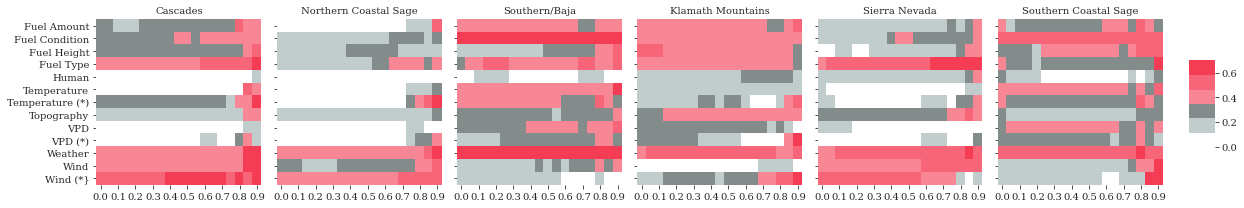

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index='Variable Type', columns='Quantile', values='r-value')
    sns.heatmap(d,**kwargs)

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(df, col="Ecoregion", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4]) 

g = g.map_dataframe(draw_heatmap,
                    cbar_ax=cbar_ax,
                    cmap=cmap,
                    vmin=0, vmax=0.7)  

g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(right=.9) 
# g.set(xlabel='Quantile')
# plt.tight_layout()
plt.savefig(f'Figures/quantile_correlation_heatmap_{resvar}.png', dpi=400)

### Entire Region

In [ ]:
def createCorrDF_ALL(orig_df, source, response_Var, resvar, var_list):
  for i in range(0, 100 + 1, 3): 
    q = i/100
    Top25_area_val = orig_df[response_Var].quantile(q)
    top25_area = orig_df[orig_df[response_Var] >= Top25_area_val].reset_index()
    top25_area = top25_area[['Date', 'Fire']]
    merged_rim_df = pd.merge(top25_area, orig_df, how='left', on=['Date', 'Fire'])
    filt_df = pd.melt(merged_rim_df, id_vars=['Fire', 'JulianDay', 'Area (ha)'], value_vars=list(var_list.keys())).dropna()
    for key in var_list: 
      df = filt_df[filt_df['variable'] == key]
      corr_val = df[response_Var].corr(df['value'])
      var_nm.append(key)
      r_val.append(abs(corr_val))
      class_val.append(var_list[key])
      hue_val.append(q)
      src.append(source)

In [ ]:
r_val = []
var_nm = [] 
class_val = []
hue_val = []
src = []

resvar = 'area'
createCorrDF_ALL(gridmet_df, 'gridmet', 'Area (ha)', resvar, gridmet_vars_list)
createCorrDF_ALL(raws_df, 'raws', 'Area (ha)', resvar, raws_vars_list)

In [ ]:
corr_df_all = pd.DataFrame({'Quantile': hue_val, 'Source': src,
                        'Variable Name': var_nm, 'r-value': r_val, 'Variable Type': class_val})
corr_df_all = corr_df_all.dropna()

In [ ]:
corr_df_all = corr_df_all[['Quantile', 'Variable Name', 'r-value','Variable Type', 'Source']]
corr_df_all = corr_df_all.loc[corr_df_all.groupby(['Variable Type', 'Quantile', 'Source'])['r-value'].idxmax()].reset_index()
corr_df_all = corr_df_all.sort_values(by=['Quantile'])

In [ ]:
class_val_dict = {
1 : 'Topography',
2 : 'Weather',
3 : 'Fuel Amount' ,
4 : 'Wind' ,
5 : 'VPD' ,
6 : 'Temperature',
7 : 'Fuel Condition',
8 : 'Human',
9 : 'Fuel Type',
10: 'Fuel Height',
}


corr_df_all = corr_df_all.replace({"Variable Type": class_val_dict})

In [ ]:
color_val_dict = {
'Fuel Type' : "#3232ff",
'Fuel Condition': "#4c4cff",
'Fuel Amount': "#7f7fff",
'Fuel Height': "#3232ff",

'Topography': "#ccccff",

'Human': "#c7d2d2",

'Weather': "#b20000",
'Wind': "#cc0000",
'Temperature': "#ff4c4c",
'VPD': "#ff7f7f",
}



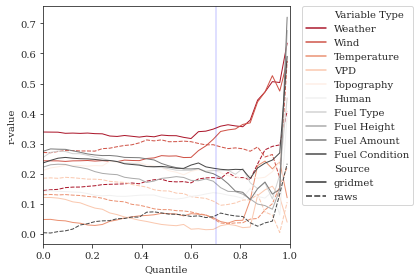

In [ ]:
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.lineplot(data=corr_df_all, 
             x="Quantile", 
             y="r-value", 
             hue_order=['Weather', 'Wind','Temperature', 
                        'VPD', #'VPD (*)',
                        'Topography', 'Human',
                        'Fuel Type', 'Fuel Height', 'Fuel Amount','Fuel Condition'
                        ],
             hue="Variable Type", style='Source', 
             palette='RdGy', linewidth=1)
plt.xlim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(0.7, color='blue', ls='-', linewidth=0.25)
plt.tight_layout()
# plt.savefig(f'Figures/quantile_correlation_heatmap_allregion_area.png', dpi=400)

In [ ]:
Top25_area_val = gridmet_df[response_Var].quantile(0.9)
top25_area = gridmet_df[gridmet_df[response_Var] >= Top25_area_val].reset_index()

In [ ]:
len(top25_area)

248

In [ ]:
top25_area.Fire.unique()

array(['Ferguson', 'Ranch', 'Thomas', 'Carr', 'Camp', 'Woolsey', 'County',
       'River', 'Stone', 'Klamathon', 'Donnell', 'Holy', 'Rush', 'Bagley',
       'Mill', 'Ponderosa', 'Barry Point', 'Fort Bagley', 'Rim',
       'Powerhouse', 'Mountain', 'Springs', 'Detwiler', 'Atlas', 'Nuns',
       'Garza', 'Tubbs', 'Alamo', 'Whittier', 'R4', 'Cascade',
       'Long Valley', 'Redwood Valley', 'Walker', 'Kincade', 'Rey',
       'Sand', 'Erskine', 'Blue Cut', 'Pulgas', 'Eiler', 'Bald', 'King',
       'Oregon Gulch', 'Washington', 'Lake', 'Route', 'Johnson', 'Fork',
       'Butte', 'Rocky', 'Valley', 'Mad River', 'Walbridge', 'Hennessey',
       'Mineral', 'Apple', 'Loyalton', 'Dome', 'W5 Cold Springs',
       'Caldwell', 'Czu Lightning', 'Slater', 'Creek', 'Del Puerto',
       'August South Zone'], dtype=object)

In [ ]:
corr_df_all

,index,Quantile,Variable Name,r-value,Variable Type,Source
0,11,0.00,TOPO_DIV,0.211189,Topography,gridmet
341,2080,0.00,Fuel_Temp_Avg,0.003764,Fuel Condition,raws
205,2088,0.00,VPD,0.185199,VPD,raws
204,26,0.00,VPD_Mean,0.120988,VPD,gridmet
442,55,0.00,Conifer,0.254413,Fuel Type,gridmet
340,7,0.00,NDMI,0.236018,Fuel Condition,gridmet
35,2082,0.00,Rel_Hum_Per,0.144270,Weather,raws
137,2077,0.00,Wind_Max_mph,0.270698,Wind,raws
408,25,0.00,travelCost,0.141106,Human,gridmet
272,23,0.00,Temp_Min,0.047755,Temperature,gridmet
